# Chapter 5 code for Julia for Machine Learning book

(c) 2020 by Zacharias Voulgaris, all rights reserved.

This code has been tested for Julia 1.4.1. 

# Initialization

## Packages

Get these packages in memory for the experiments that follow.

In [1]:
using CSV, DataFrames;

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1260


In [2]:
using Clustering, DecisionTree, GLM, XGBoost;

┌ Info: Precompiling Clustering [aaaa29a8-35af-508c-8bc3-b662a17a0fe5]
└ @ Base loading.jl:1260
┌ Info: Precompiling DecisionTree [7806a523-6efd-50cb-b5f6-3fa6f1930dbb]
└ @ Base loading.jl:1260
┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1260
┌ Info: Precompiling XGBoost [009559a3-9522-5dbb-924b-0b6ed2b22bb9]
└ @ Base loading.jl:1260


In [4]:
using StatsBase, Distributions, HypothesisTests, MultivariateStats;

┌ Info: Precompiling HypothesisTests [09f84164-cd44-5f33-b23f-e6b0d136a0d5]
└ @ Base loading.jl:1260
┌ Info: Precompiling MultivariateStats [6f286f6a-111f-5878-ab1e-185364afe411]
└ @ Base loading.jl:1260


In [5]:
using Distances, MLLabelUtils, MLBase;

┌ Info: Precompiling MLLabelUtils [66a33bbf-0c2b-5fc8-a008-9da813334f0a]
└ @ Base loading.jl:1260
┌ Info: Precompiling MLBase [f0e99cf1-93fa-52ec-9ecc-5026115318e0]
└ @ Base loading.jl:1260


In [6]:
using TSne, Gadfly;

┌ Info: Precompiling TSne [24678dba-d5e9-5843-a4c6-250288b04835]
└ @ Base loading.jl:1260
┌ Info: Precompiling Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1260


In [7]:
using ScikitLearn.CrossValidation: cross_val_score;

┌ Info: Precompiling ScikitLearn [3646fa90-6ef7-5e7e-9f22-8aca16db6324]
└ @ Base loading.jl:1260


In [37]:
using Random;

Note: if you got an alarming large area of red in the outputs of these commands, don't panic. Most of these are just warnings that most likely won't affect the experience of using these packages. Also, the first time you run these packages it is bound to take more time than other times.
 

## Auxiliary functions

In [48]:
function partition(ind::Union{Array{Int64, 1}, UnitRange{Int64}}, r::Float64, shuffle::Bool = true)
    if typeof(ind) == UnitRange{Int64}; ind = collect(ind); end
    N = length(ind) # total number of data points in sample
    n = round(Int64, N*r) # number of data points in training set (train)
    train = [0, 0] # initialize train output
    test = [0, 0] # initialize test output
    
    if shuffle        
        ind_ = ind[randperm(N)]
    else
        ind_ = ind
    end
    
    train = ind_[1:n]
    test = ind_[(n+1):end]
    return train, test
end

partition (generic function with 2 methods)

# Load data from localization.csv file

In [8]:
df = CSV.read("localization.csv", header = false);

In [9]:
old_names = names(df)

8-element Array{Symbol,1}:
 :Column1
 :Column2
 :Column3
 :Column4
 :Column5
 :Column6
 :Column7
 :Column8

In [10]:
new_names = map(Symbol, ["WiFi1", "WiFi2", "WiFi3", "WiFi4", "WiFi5", "WiFi6", "WiFi7", "Room"])

8-element Array{Symbol,1}:
 :WiFi1
 :WiFi2
 :WiFi3
 :WiFi4
 :WiFi5
 :WiFi6
 :WiFi7
 :Room

In [11]:
for i = 1:8
    rename!(df, old_names[i] => new_names[i])
end

In [12]:
names(df)

8-element Array{Symbol,1}:
 :WiFi1
 :WiFi2
 :WiFi3
 :WiFi4
 :WiFi5
 :WiFi6
 :WiFi7
 :Room

In [13]:
df[:RegressionTarget] = Matrix(df[[1, 4, 6, 7]]) * [5, 10, 15, 20] + 0.01*randn(2000)

2000-element Array{Float64,1}:
 -3830.0069783707195
 -3965.0017120503444
 -3939.9940514373093
 -3874.998805435396
 -3899.982603085643
 -3959.994619335375
 -3979.9855577556496
 -3909.991138479228
 -3884.992913856418
 -4099.997170328259
 -4070.0075465522955
 -3904.980097278042
 -3905.0116585296896
     ⋮
 -3815.0092078332173
 -3654.9869456209744
 -3779.981154456118
 -3719.9845818539197
 -3970.0066150745024
 -4009.9826738372853
 -4000.009174872777
 -4124.988932896469
 -4020.002692892853
 -4024.999458196738
 -3970.0007856428856
 -3954.9970686098936

In [14]:
first(df, 10)

10×9 DataFrame. Omitted printing of 1 columns
│ Row │ WiFi1 │ WiFi2 │ WiFi3 │ WiFi4 │ WiFi5 │ WiFi6 │ WiFi7 │ Room  │
│     │ Int64 │ Int64 │ Int64 │ Int64 │ Int64 │ Int64 │ Int64 │ Int64 │
├─────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ 1   │ -64   │ -56   │ -61   │ -66   │ -71   │ -82   │ -81   │ 1     │
│ 2   │ -68   │ -57   │ -61   │ -65   │ -71   │ -85   │ -85   │ 1     │
│ 3   │ -63   │ -60   │ -60   │ -67   │ -76   │ -85   │ -84   │ 1     │
│ 4   │ -61   │ -60   │ -68   │ -62   │ -77   │ -90   │ -80   │ 1     │
│ 5   │ -63   │ -65   │ -60   │ -63   │ -77   │ -81   │ -87   │ 1     │
│ 6   │ -64   │ -55   │ -63   │ -66   │ -76   │ -88   │ -83   │ 1     │
│ 7   │ -65   │ -61   │ -65   │ -67   │ -69   │ -87   │ -84   │ 1     │
│ 8   │ -61   │ -63   │ -58   │ -66   │ -74   │ -87   │ -82   │ 1     │
│ 9   │ -65   │ -60   │ -59   │ -63   │ -76   │ -86   │ -82   │ 1     │
│ 10  │ -62   │ -60   │ -66   │ -68   │ -80   │ -86   │ -91   │ 1     │

# Work the data using StatsBase package

In [15]:
XX = map(Float64, Matrix(df[1:7]));

In [17]:
X = StatsBase.standardize(ZScoreTransform, XX, dims=2)

2000×7 Array{Float64,2}:
 0.478077   1.28936   0.782308   0.275256    -0.231795   -1.34731   -1.2459
 0.207303   1.20495   0.84217    0.479389    -0.0647823  -1.33451   -1.33451
 0.708444   0.98395   0.98395    0.341103    -0.485416   -1.31193   -1.2201
 0.884579   0.971791  0.274095   0.797367    -0.510813   -1.64457   -0.772449
 0.739762   0.551459  1.02222    0.739762    -0.578359   -0.954965  -1.51987
 0.563639   1.31916   0.647586   0.395747    -0.443716   -1.45107   -1.03134
 0.605834   1.00033   0.605834   0.408586     0.211337   -1.5639    -1.26802
 0.823905   0.643676  1.09425    0.373332    -0.347585   -1.51908   -1.0685
 0.465976   0.919009  1.00962    0.647189    -0.530695   -1.43676   -1.07433
 0.918708   1.08152   0.59309    0.430281    -0.546573   -1.035     -1.44202
 0.489995   1.01768   0.929733   0.489995    -0.389483   -0.917169  -1.62075
 0.50721    1.09895   0.901707   0.309962    -0.183159   -1.5639    -1.07078
 0.598345   1.14466   0.78045    0.41624     -0.31218

In [18]:
df2 = DataFrame(hcat(X, df[:Room]))

2000×8 DataFrame. Omitted printing of 2 columns
│ Row  │ x1        │ x2       │ x3       │ x4         │ x5         │ x6        │
│      │ Float64   │ Float64  │ Float64  │ Float64    │ Float64    │ Float64   │
├──────┼───────────┼──────────┼──────────┼────────────┼────────────┼───────────┤
│ 1    │ 0.478077  │ 1.28936  │ 0.782308 │ 0.275256   │ -0.231795  │ -1.34731  │
│ 2    │ 0.207303  │ 1.20495  │ 0.84217  │ 0.479389   │ -0.0647823 │ -1.33451  │
│ 3    │ 0.708444  │ 0.98395  │ 0.98395  │ 0.341103   │ -0.485416  │ -1.31193  │
│ 4    │ 0.884579  │ 0.971791 │ 0.274095 │ 0.797367   │ -0.510813  │ -1.64457  │
│ 5    │ 0.739762  │ 0.551459 │ 1.02222  │ 0.739762   │ -0.578359  │ -0.954965 │
│ 6    │ 0.563639  │ 1.31916  │ 0.647586 │ 0.395747   │ -0.443716  │ -1.45107  │
│ 7    │ 0.605834  │ 1.00033  │ 0.605834 │ 0.408586   │ 0.211337   │ -1.5639   │
│ 8    │ 0.823905  │ 0.643676 │ 1.09425  │ 0.373332   │ -0.347585  │ -1.51908  │
│ 9    │ 0.465976  │ 0.919009 │ 1.00962  │ 0.647189   │ -0.530695  │ -1.43676  │
│ 10   │ 0.918708  │ 1.08152  │ 0.59309  │ 0.430281   │ -0.546573  │ -1.035    │
⋮
│ 1990 │ 0.424393  │ 0.502571 │ 0.580749 │ 0.0335047  │ 1.20617    │ -1.37369  │
│ 1991 │ 0.268086  │ 0.462217 │ 0.785769 │ 0.00924434 │ 1.17403    │ -1.15554  │
│ 1992 │ 0.0831825 │ 0.471368 │ 0.988948 │ 0.212578   │ 0.988948   │ -1.34016  │
│ 1993 │ 0.455231  │ 0.516512 │ 0.700355 │ 0.148825   │ 1.00676    │ -1.3832   │
│ 1994 │ 0.138531  │ 0.62339  │ 0.926427 │ 0.138531   │ 0.926427   │ -1.55848  │
│ 1995 │ 0.17398   │ 0.579934 │ 0.753914 │ 0.0579934  │ 1.15987    │ -1.33385  │
│ 1996 │ 0.39736   │ 0.39736  │ 1.02178  │ 0.0        │ 0.908251   │ -1.13531  │
│ 1997 │ 0.315023  │ 0.489115 │ 0.837298 │ 0.140931   │ 1.01139    │ -1.30983  │
│ 1998 │ 0.147736  │ 0.320095 │ 1.06698  │ -0.0246227 │ 1.12444    │ -1.28859  │
│ 1999 │ 0.122404  │ 0.350891 │ 0.693621 │ 0.179526   │ 1.32196    │ -1.47701  │
│ 2000 │ 0.162858  │ 0.65143  │ 0.92286  │ 0.108572   │ 0.92286    │ -1.41143  │

In [19]:
for i = 1:8
    rename!(df2, names(df2)[i] => new_names[i])
end

In [20]:
first(df2, 10)

10×8 DataFrame. Omitted printing of 2 columns
│ Row │ WiFi1    │ WiFi2    │ WiFi3    │ WiFi4    │ WiFi5      │ WiFi6     │
│     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64    │ Float64   │
├─────┼──────────┼──────────┼──────────┼──────────┼────────────┼───────────┤
│ 1   │ 0.478077 │ 1.28936  │ 0.782308 │ 0.275256 │ -0.231795  │ -1.34731  │
│ 2   │ 0.207303 │ 1.20495  │ 0.84217  │ 0.479389 │ -0.0647823 │ -1.33451  │
│ 3   │ 0.708444 │ 0.98395  │ 0.98395  │ 0.341103 │ -0.485416  │ -1.31193  │
│ 4   │ 0.884579 │ 0.971791 │ 0.274095 │ 0.797367 │ -0.510813  │ -1.64457  │
│ 5   │ 0.739762 │ 0.551459 │ 1.02222  │ 0.739762 │ -0.578359  │ -0.954965 │
│ 6   │ 0.563639 │ 1.31916  │ 0.647586 │ 0.395747 │ -0.443716  │ -1.45107  │
│ 7   │ 0.605834 │ 1.00033  │ 0.605834 │ 0.408586 │ 0.211337   │ -1.5639   │
│ 8   │ 0.823905 │ 0.643676 │ 1.09425  │ 0.373332 │ -0.347585  │ -1.51908  │
│ 9   │ 0.465976 │ 0.919009 │ 1.00962  │ 0.647189 │ -0.530695  │ -1.43676  │
│ 10  │ 0.918708 │ 1.08152  │ 0.59309  │ 0.430281 │ -0.546573  │ -1.035    │

Note: the localization dataset is used as an example as it's fairly straight-forward and doesn't require pretty much any data engineering. Feel free to experiment with different datasets, for your predictive analytics projects.
 

# Work the data using Clustering package

In [21]:
nc = 4; # number of clusters

In [22]:
n, m = size(X)
XX = Array{Float64}(undef, m, n);

for i = 1:m
    XX[i,:] = X[:,i]
end

# alternatively, if you use the LinearAlgebra package, you can do the same thing as follows: XX = collect(adjoint(X))

In [23]:
R = kmeans(XX, nc; maxiter=200, display=:iter) # the second part of the arguments is optional but useful in a demo

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       9.755951e+02
      1       6.002662e+02      -3.753290e+02 |        4
      2       5.939657e+02      -6.300510e+00 |        4
      3       5.931473e+02      -8.183441e-01 |        3
      4       5.929714e+02      -1.758895e-01 |        4
      5       5.928330e+02      -1.384317e-01 |        4
      6       5.927874e+02      -4.561082e-02 |        2
      7       5.927846e+02      -2.736709e-03 |        2
      8       5.927806e+02      -3.995273e-03 |        2
      9       5.927765e+02      -4.110869e-03 |        2
     10       5.927746e+02      -1.906026e-03 |        0
     11       5.927746e+02       0.000000e+00 |        0
K-means converged with 11 iterations (objv = 592.7746327267683)


KmeansResult{Array{Float64,2},Float64,Int64}([0.26238417553381865 1.2844768060034517 0.8769515164186158 0.5487145680672613; 0.5655365389473563 0.0844232322568441 0.48301843203430944 1.1014656023191367; … ; -1.3864954602844533 -0.977303843601885 -1.3236144007357722 -1.2636315228294133; -1.3837043727428167 -1.025863510588361 -1.3824438212028833 -1.362797062959029], [4, 4, 4, 3, 3, 4, 4, 4, 4, 4  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0.0878974329160549, 0.16056244712318346, 0.25337128965280087, 1.0196079056837046, 0.5699422976343183, 0.2895467026984715, 0.2499516379654132, 0.6203431393935936, 0.4515746724659895, 0.37762907883710106  …  0.19383882421588794, 0.07195790384627898, 0.07367341979481346, 0.09405132904213431, 0.09713508747414501, 0.22053401659064953, 0.03677470319603238, 0.2264529096588035, 0.3006991987272265, 0.03198291753014715], [501, 472, 522, 505], [501, 472, 522, 505], 592.7746327267683, 11, true)

In [24]:
@assert nclusters(R) == nc # although it's pretty obvious from the previous output that the number of clusters is indeed 4, it doesn't hurt to verify it

In [25]:
a = assignments(R) # assignments (labels) of the various points of the datasets, according to the Kmeans model

2000-element Array{Int64,1}:
 4
 4
 4
 3
 3
 4
 4
 4
 4
 4
 4
 4
 4
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [26]:
c = counts(R) # Cluster sizes

4-element Array{Int64,1}:
 501
 472
 522
 505

In [27]:
M = (R.centers)' # cluster centers (centroids), transposed for easier viewing

4×7 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 0.262384  0.565537   0.840882   0.189405   0.911992   -1.3865    -1.3837
 1.28448   0.0844232  0.0933737  1.22007   -0.679172   -0.977304  -1.02586
 0.876952  0.483018   0.634199   0.803377  -0.0914876  -1.32361   -1.38244
 0.548715  1.10147    0.720186   0.397016  -0.140954   -1.26363   -1.3628

In [28]:
R2 = fuzzy_cmeans(XX, nc, 2, maxiter=200, display=:iter) # 2 is the fuzziness parameter (needs to be > 1)

  Iters      center-change
----------------------------
      1       2.200882e+00
      2       3.340089e-02
      3       5.949422e-02
      4       1.183473e-01
      5       2.114072e-01
      6       2.902490e-01
      7       2.734240e-01
      8       2.003597e-01
      9       1.527291e-01
     10       8.514587e-02
     11       4.207335e-02
     12       2.153346e-02
     13       1.098799e-02
     14       5.525786e-03
     15       2.749342e-03
     16       1.360195e-03
     17       6.715476e-04
Fuzzy C-means converged with 17 iterations (δ = 0.000671547625210737)


FuzzyCMeansResult: 4 clusters for 2000 points in 7 dimensions (converged in 17 iterations)

In [29]:
M2 = (R2.centers)' # the centroids, transposed for easier viewing

4×7 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 1.28717   0.0770322  0.0847606  1.22361   -0.674913  -0.97433  -1.02333
 0.269108  0.567273   0.836389   0.194895   0.89736   -1.38372  -1.3813
 0.583787  1.02737    0.713235   0.439652  -0.122885  -1.26461  -1.37655
 0.859764  0.517633   0.616597   0.799301  -0.120308  -1.31017  -1.36281

In [30]:
memberships = R2.weights # how much each data point belongs to each one of the (4) clusters according to Cmeans

2000×4 Array{Float64,2}:
 0.0301643   0.0628639  0.797242   0.10973
 0.0350371   0.102633   0.724126   0.138205
 0.0569435   0.0709893  0.646009   0.226058
 0.203777    0.0961639  0.326162   0.373898
 0.131293    0.0847523  0.327086   0.456868
 0.0673989   0.0850703  0.647454   0.200077
 0.0393802   0.148176   0.598302   0.214142
 0.0873073   0.112754   0.415004   0.384935
 0.0824831   0.0914269  0.521894   0.304196
 0.091648    0.0678088  0.557678   0.282865
 0.060731    0.085672   0.630245   0.223352
 0.0449438   0.101846   0.673427   0.179783
 0.0174029   0.0272705  0.875805   0.0795217
 ⋮                                 
 0.00873983  0.92941    0.032157   0.0296936
 0.0276762   0.824105   0.0784235  0.0697955
 0.024805    0.839758   0.0731491  0.0622884
 0.0110872   0.920603   0.037298   0.0310118
 0.0120306   0.91151    0.0405997  0.0358594
 0.0135957   0.896537   0.0509527  0.0389142
 0.0138891   0.905795   0.0444388  0.035877
 0.0288896   0.793803   0.095844   0.0814635
 0.00635

# Work the data using predictive ML models

## Prepare data for ML models

In [31]:
X = df2[1:7];

In [32]:
XX = map(Float64, Matrix(X));

In [33]:
y1 = map(string, df[:Room]);

In [34]:
y2 = df[end];

In [49]:
train, test = partition(1:n, 0.7, true) # 70-30 split of the data

([1691, 1050, 1970, 362, 220, 1700, 1307, 1584, 1135, 1064  …  1180, 827, 894, 1292, 1174, 1932, 1403, 376, 1527, 316], [252, 256, 1454, 1813, 1494, 791, 838, 1577, 1907, 1074  …  1872, 1004, 1537, 1619, 151, 1964, 896, 1175, 1894, 754])

## Build and run the ML models

### Decision Tree

In [50]:
tree = DecisionTreeClassifier(max_depth=3);

In [51]:
DecisionTree.fit!(tree, XX[train,:], y1[train])

DecisionTreeClassifier
max_depth:                3
min_samples_leaf:         1
min_samples_split:        2
min_purity_increase:      0.0
pruning_purity_threshold: 1.0
n_subfeatures:            0
classes:                  ["1", "2", "3", "4"]
root:                     Decision Tree
Leaves: 7
Depth:  3

In [52]:
print_tree(tree)

Feature 5, Threshold 0.4224564984399155
L-> Feature 2, Threshold 0.769088926919767
    L-> Feature 5, Threshold -0.3126906029256431
        L-> 2 : 315/357
        R-> 3 : 288/344
    R-> Feature 2, Threshold 0.9728068903444258
        L-> 1 : 65/87
        R-> 1 : 256/258
R-> Feature 5, Threshold 0.6042511496066855
    L-> Feature 2, Threshold 0.8139075864128726
        L-> 4 : 19/19
        R-> 1 : 3/5
    R-> 4 : 330/330


In [53]:
yhat = DecisionTree.predict(tree, XX[test,:])

600-element Array{String,1}:
 "1"
 "3"
 "3"
 "4"
 "2"
 "2"
 "2"
 "4"
 "4"
 "4"
 "3"
 "2"
 "2"
 ⋮
 "3"
 "3"
 "4"
 "3"
 "4"
 "4"
 "1"
 "4"
 "2"
 "1"
 "4"
 "2"

In [54]:
sum(yhat .== y1[test]) / length(test)

0.92

In [55]:
accuracy = cross_val_score(tree, XX, y1, cv=5)

5-element Array{Float64,1}:
 0.8075
 0.9075
 0.895
 0.89
 0.87

### Random Forests

In [56]:
n_subfeatures = 3;
n_trees = 10;
pst = 0.5; # portion of samples per tree
max_depth = 6;
n_folds = 5; # number of folds for the K-fold cross-validation later on

In [57]:
forest1 = build_forest(y1[train], XX[train,:], n_subfeatures, n_trees, pst, max_depth);

In [58]:
yhat = apply_forest(forest1, XX[test,:])

600-element Array{String,1}:
 "1"
 "3"
 "3"
 "4"
 "3"
 "2"
 "2"
 "4"
 "4"
 "4"
 "3"
 "2"
 "2"
 ⋮
 "3"
 "3"
 "4"
 "3"
 "4"
 "4"
 "1"
 "4"
 "2"
 "3"
 "4"
 "2"

In [59]:
scores = apply_forest_proba(forest1, XX[test,:], map(string, 1:4)) # map(string, 1:4) => ["1", "2", "3", "4"] but it's more elegant and less risky

600×4 Array{Float64,2}:
 1.0  0.0  0.0  0.0
 0.2  0.0  0.8  0.0
 0.0  0.0  0.9  0.1
 0.0  0.0  0.0  1.0
 0.0  0.3  0.7  0.0
 0.0  1.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0
 0.1  0.0  0.2  0.7
 0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.9  0.1  0.0
 ⋮              
 0.0  0.0  1.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.1  0.9
 1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0
 0.0  1.0  0.0  0.0
 0.4  0.0  0.6  0.0
 0.0  0.0  0.0  1.0
 0.0  0.9  0.1  0.0

In [60]:
accuracy = nfoldCV_forest(y1, XX, n_folds, n_subfeatures)


Fold 1
Classes:  

4×4 Array{Int64,2}:
 92    0    1   0
  0  110    0   0
  0    0  101   0
  0    0    0  96

["1", "2", "3", "4"]
Matrix:   
Accuracy: 

4×4 Array{Int64,2}:
 100    0   0    0
   0  110   0    0
   1    1  88    0
   0    0   0  100

4×4 Array{Int64,2}:
 107   0    0   1
   0  93    1   0
   3   3  104   0
   0   0    0  88

4×4 Array{Int64,2}:
 94    0   1    0
  0  101   0    0
  4    1  96    0
  0    0   0  103

0.9975
Kappa:    0.9966618263148233

Fold 2
Classes:  ["1", "2", "3", "4"]
Matrix:   
Accuracy: 0.995
Kappa:    0.9933205310177841

Fold 3
Classes:  ["1", "2", "3", "4"]
Matrix:   
Accuracy: 0.98
Kappa:    0.973269625941828

Fold 4
Classes:  ["1", "2", "3", "4"]
Matrix:   
Accuracy: 0.985
Kappa:    0.9799969995499324


4×4 Array{Int64,2}:
 102   0   2    0
   0  85   0    0
   2   1  95    0
   0   0   0  113


Fold 5
Classes:  ["1", "2", "3", "4"]
Matrix:   
Accuracy: 0.9875
Kappa:    0.9832774521526101

Mean Accuracy: 0.9890000000000001


5-element Array{Float64,1}:
 0.9975
 0.995
 0.98
 0.985
 0.9875

In [61]:
forest2 = build_forest(y2[train], XX[train,:], 2, 10, 0.5, 6);

In [62]:
apply_forest(forest2, XX[test,:])

600-element Array{Float64,1}:
 -3853.2423072896977
 -3740.4226879771913
 -3493.5949128601396
 -3911.2690323091942
 -3547.168848807572
 -3153.418678763528
 -3051.669478134517
 -3960.935291369488
 -3955.021552016581
 -3719.40567016616
 -3508.4975252013146
 -3183.872485745293
 -3272.3738525246686
     ⋮
 -3654.804234911599
 -3656.279490474273
 -4080.000823728887
 -3644.508207867276
 -3901.680240410992
 -3891.620130690385
 -3869.014834437125
 -3907.8406049993064
 -3253.3382787962187
 -3807.6319697420186
 -3944.5015336743213
 -3405.738641075621

In [63]:
accuracy = nfoldCV_forest(y2, XX, n_folds, n_subfeatures)


Fold 1
Mean Squared Error:     7997.655534522757
Correlation Coeff:      0.9709745425858305
Coeff of Determination: 0.9420854955232201

Fold 2
Mean Squared Error:     9404.842196788677
Correlation Coeff:      0.9611291228283666
Coeff of Determination: 0.923227743741539

Fold 3
Mean Squared Error:     8113.307682087167
Correlation Coeff:      0.9675590823146837
Coeff of Determination: 0.9347597016108636

Fold 4
Mean Squared Error:     8657.795163926023
Correlation Coeff:      0.9674235709993337
Coeff of Determination: 0.9352270725884039

Fold 5
Mean Squared Error:     7064.650978917489
Correlation Coeff:      0.9695760131955281
Coeff of Determination: 0.939659563248007

Mean Coeff of Determination: 0.9349919153424068


5-element Array{Float64,1}:
 0.9420854955232201
 0.923227743741539
 0.9347597016108636
 0.9352270725884039
 0.939659563248007

In [64]:
ni = 10 # number of iterations for boosted stumps

10

In [65]:
model, coeffs = build_adaboost_stumps(y1[train], XX[train,:], ni)

(Ensemble of Decision Trees
Trees:      10
Avg Leaves: 2.0
Avg Depth:  1.0, [0.540771086448253, 0.3106780625500361, 0.4775221695086646, 0.4480389482465397, 0.5239041296311151, 0.49296046420809675, 0.49471266986837814, 0.40745889451070594, 0.5216954083374497, 0.3075399359581831])

In [66]:
apply_adaboost_stumps(model, coeffs, XX[test,:])

600-element Array{String,1}:
 "1"
 "3"
 "3"
 "4"
 "2"
 "2"
 "3"
 "4"
 "4"
 "4"
 "3"
 "2"
 "3"
 ⋮
 "3"
 "3"
 "4"
 "3"
 "4"
 "4"
 "1"
 "4"
 "2"
 "1"
 "4"
 "2"

In [67]:
apply_adaboost_stumps_proba(model, coeffs, XX[test,:], map(string, 1:4))

600×4 Array{Float64,2}:
 0.514556  0.327443   0.158001  0.0
 0.224607  0.0        0.447951  0.327443
 0.224607  0.327443   0.447951  0.0
 0.115285  0.0        0.37999   0.504725
 0.109322  0.532768   0.35791   0.0
 0.109322  0.532768   0.35791   0.0
 0.109322  0.442727   0.447951  0.0
 0.115285  0.0        0.37999   0.504725
 0.115285  0.0        0.37999   0.504725
 0.224607  0.0        0.37999   0.395403
 0.224607  0.0900406  0.35791   0.327443
 0.109322  0.532768   0.35791   0.0
 0.109322  0.442727   0.447951  0.0
 ⋮                              
 0.224607  0.0        0.447951  0.327443
 0.109322  0.115285   0.447951  0.327443
 0.115285  0.0        0.37999   0.504725
 0.224607  0.0        0.447951  0.327443
 0.289462  0.0        0.205813  0.504725
 0.224607  0.0        0.37999   0.395403
 0.514556  0.327443   0.158001  0.0
 0.115285  0.0        0.37999   0.504725
 0.109322  0.532768   0.35791   0.0
 0.398784  0.327443   0.273774  0.0
 0.115285  0.0        0.37999   0.504725
 0.224607

In [68]:
accuracy = nfoldCV_stumps(y1, XX, n_folds, ni)

4×4 Array{Int64,2}:
 92   0  11   0
  0  79  12   0
  7  10  89   1
  2   0   3  94

4×4 Array{Int64,2}:
 91   0   9    0
  0   0  94    0
  4  17  77    1
  6   0   0  101

4×4 Array{Int64,2}:
 92   0   5   0
  0  95   6   0
 14  22  64   0
 33   1   0  68

4×4 Array{Int64,2}:
 102   0   2   0
   0  97  11   0
  10  16  65   0
  31   0   0  66

4×4 Array{Int64,2}:
 90   0   5   1
  0  91  15   0
  9   2  92   0
  0   0  85  10


Fold 1
Classes:  ["1", "2", "3", "4"]
Matrix:   
Accuracy: 0.885
Kappa:    0.8463952983604368

Fold 2
Classes:  ["1", "2", "3", "4"]
Matrix:   
Accuracy: 0.6725
Kappa:    0.5617556536866051

Fold 3
Classes:  ["1", "2", "3", "4"]
Matrix:   
Accuracy: 0.7975
Kappa:    0.7303662525070111

Fold 4
Classes:  ["1", "2", "3", "4"]
Matrix:   
Accuracy: 0.825
Kappa:    0.7655412647374061

Fold 5
Classes:  ["1", "2", "3", "4"]
Matrix:   
Accuracy: 0.7075
Kappa:    0.6077182276910698

Mean Accuracy: 0.7775


5-element Array{Float64,1}:
 0.885
 0.6725
 0.7975
 0.825
 0.7075

If this isn't an overfit model, I don't know what is!
 

# ML utilities packages

## MLBase functions

For the love of God, don't bother with the label functions of this package as they are a nightmare to figure out and do something useful with them! Fortunately, there is the MLLabelsUtils package for this (see next section).

### Preprocessing target and prediction variables

In [69]:
pred = map(x -> parse(Int64, x), yhat); # prediction of RF classifier

In [70]:
gt = map(x -> parse(Int64, x), y1[test]); # ground truth for classification

In [71]:
conf = maximum(scores, dims=2)[:]; # confidence scores for RF classifier

In [72]:
k = length(unique(gt)); # number of classes

### Performance evaluation functions for classification

In [73]:
correctrate(gt, pred) # accuracy rate

0.9516666666666667

In [74]:
confusmat(k, gt, pred) # confusion matrix for the RF classifier

4×4 Array{Int64,2}:
 152    0    6    0
   0  141    6    0
   6    9  135    1
   0    0    1  143

In [75]:
ROC =  roc(gt, conf) # Receiver Operator Characteristic data (for building an ROC curve) for RFC

100-element Array{ROCNums{Int64},1}:
 ROCNums{Int64}
  p = 600
  n = 0
  tp = 600
  tn = 0
  fp = 0
  fn = 0

 ROCNums{Int64}
  p = 600
  n = 0
  tp = 590
  tn = 0
  fp = 0
  fn = 10

 ROCNums{Int64}
  p = 600
  n = 0
  tp = 590
  tn = 0
  fp = 0
  fn = 10

 ROCNums{Int64}
  p = 600
  n = 0
  tp = 590
  tn = 0
  fp = 0
  fn = 10

 ROCNums{Int64}
  p = 600
  n = 0
  tp = 590
  tn = 0
  fp = 0
  fn = 10

 ROCNums{Int64}
  p = 600
  n = 0
  tp = 590
  tn = 0
  fp = 0
  fn = 10

 ROCNums{Int64}
  p = 600
  n = 0
  tp = 590
  tn = 0
  fp = 0
  fn = 10

 ROCNums{Int64}
  p = 600
  n = 0
  tp = 590
  tn = 0
  fp = 0
  fn = 10

 ROCNums{Int64}
  p = 600
  n = 0
  tp = 590
  tn = 0
  fp = 0
  fn = 10

 ROCNums{Int64}
  p = 600
  n = 0
  tp = 590
  tn = 0
  fp = 0
  fn = 10

 ROCNums{Int64}
  p = 600
  n = 0
  tp = 590
  tn = 0
  fp = 0
  fn = 10

 ROCNums{Int64}
  p = 600
  n = 0
  tp = 590
  tn = 0
  fp = 0
  fn = 10

 ROCNums{Int64}
  p = 600
  n = 0
  tp = 590
  tn = 0
  fp = 0
  fn = 10

 ⋮

In [76]:
r = ROC[50] # a particular instance of the ROC data array

ROCNums{Int64}
  p = 600
  n = 0
  tp = 547
  tn = 0
  fp = 0
  fn = 53


In [77]:
precision(r)

1.0

In [78]:
recall(r)

0.9116666666666666

In [79]:
f1score(r)

0.953792502179599

### Crossvalidation functions

In [80]:
n = length(y1) # total number of data points
k = round(Int64, 0.3*n) # size of a sample for test set
sn = 5 # number of samples

5

In [81]:
Kfold(n, k)

Kfold([319, 407, 1686, 442, 974, 994, 588, 1298, 385, 224  …  499, 1164, 1137, 1900, 1618, 1466, 995, 1932, 946, 42], 600, 3.3333333333333335)

In [82]:
LOOCV(n)

LOOCV(2000)

In [83]:
RandomSub(n, sn, k)

RandomSub(2000, 5, 600)

## MLLabelsUtils functions

In [84]:
y1[rand(1:n, 20)] # 20 random labels just to remind ourselves of what the classification target variable is like

20-element Array{String,1}:
 "4"
 "2"
 "2"
 "3"
 "2"
 "1"
 "1"
 "1"
 "3"
 "1"
 "1"
 "2"
 "2"
 "3"
 "4"
 "4"
 "1"
 "1"
 "1"
 "2"

In [85]:
labelenc(y1)

MLLabelUtils.LabelEnc.NativeLabels{String,4,typeof(identity)}(identity, ["1", "2", "3", "4"], Dict("4" => 4,"1" => 1,"2" => 2,"3" => 3))

In [86]:
islabelenc(y1, LabelEnc.ZeroOne)

false

In [87]:
convertlabel([:Room1,:Room2,:Room3,:Room4], y1)

2000-element Array{Symbol,1}:
 :Room1
 :Room1
 :Room1
 :Room1
 :Room1
 :Room1
 :Room1
 :Room1
 :Room1
 :Room1
 :Room1
 :Room1
 :Room1
 ⋮
 :Room4
 :Room4
 :Room4
 :Room4
 :Room4
 :Room4
 :Room4
 :Room4
 :Room4
 :Room4
 :Room4
 :Room4

In [88]:
convertlabel(LabelEnc.Indices{Int}, y1) 

2000-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 4
 4
 4
 4
 4
 4
 4
 4
 4
 4
 4
 4

In [89]:
convertlabel(LabelEnc.OneOfK{Bool}, y1)

4×2000 BitArray{2}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  1  1  1  1  1  1  1  1  1  1

In [90]:
convertlabel(LabelEnc.OneOfK{Float64}, y1)

4×2000 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [91]:
convertlabel(LabelEnc.TrueFalse, y1, LabelEnc.OneVsRest("1"))

2000-element BitArray{1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [92]:
scores[1:10,:] # confidence scores for the RF classifier

10×4 Array{Float64,2}:
 1.0  0.0  0.0  0.0
 0.2  0.0  0.8  0.0
 0.0  0.0  0.9  0.1
 0.0  0.0  0.0  1.0
 0.0  0.3  0.7  0.0
 0.0  1.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0
 0.1  0.0  0.2  0.7

In [93]:
MLLabelUtils.classify(scores[1:10,:]', LabelEnc.OneOfK) # note: the scores are transposed using the ' operator

10-element Array{Int64,1}:
 1
 3
 3
 4
 3
 2
 2
 4
 4
 4

# Make Use of the "Other" Packages for Some Cool Plots

## Distances package

In [94]:
D = [Euclidean(), Cityblock(), Jaccard(), CosineDist(), CorrDist()];

In [95]:
y = map(Float64, y2);

In [96]:
for dist in D
    println(Distances.evaluate(dist, X[:,1], y2))
end

163892.04974572547
7.29471680026241e6
1.0002019124866512
1.8255458958481885
0.16171531220531588


In [97]:
CosineDist()(X[:,1], y2)

1.8255458958481885

In [106]:
D = pairwise(Jaccard(), XX, dims=2)

7×7 Array{Float64,2}:
 0.0       0.639451  0.613079  0.294575  1.1623    1.49512   1.4853
 0.639451  0.0       0.418661  0.692826  0.925327  1.44044   1.42505
 0.613079  0.418661  0.0       0.662106  0.860528  1.46498   1.44685
 0.294575  0.692826  0.662106  0.0       1.19257   1.4405    1.43452
 1.1623    0.925327  0.860528  1.19257   0.0       1.01864   1.01747
 1.49512   1.44044   1.46498   1.4405    1.01864   0.0       0.193714
 1.4853    1.42505   1.44685   1.43452   1.01747   0.193714  0.0

Note that the pairwise function works only with matrices, hence the use of XX here instead of X (X is a dataframe)

## Gadfly package

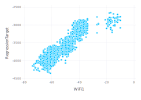

In [107]:
plot(df, x = :WiFi1, y = :RegressionTarget)

Clearly there is a trend here, showing that the RegressionTarget variable is related to the WiFi1 variable

In [108]:
plot(df2, x = :WiFi1, y = :WiFi2, color = :Room)

In [109]:
plot(df3, x = :x1, y = :x2, color = :x3)

UndefVarError: UndefVarError: df3 not defined

In [110]:
plot(df2, x = "WiFi1", Geom.histogram)

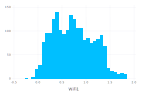

In [111]:
plot(df2, x = "WiFi1", Geom.histogram(bincount=30))

In [112]:
plot(df2, x=:WiFi1, y=:WiFi2, Geom.histogram2d(xbincount=40, ybincount=40))

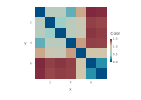

In [113]:
spy(D) # heatmap of the Jaccard distance matrix from a previous section

# Sandbox

A place for you to experiment with the above material, without making a mess of the whole notebook or disrupt its flow. It's much easier to maintain this section than keep track of various copies of this notebook.